In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# !pip install psycopg2-binary
import psycopg2

In [2]:
# create a database connection
sqluser = 'asem'
dbname = 'mimiciv'
hostname = 'localhost'
password='qwerasdf'
# hosp_schema_name = 'mimiciv_hosp'

# Connect to local postgres version of mimic
con = psycopg2.connect(dbname=dbname, user=sqluser, host=hostname, password=password)

In [3]:
query = \
"""
SELECT
      pat.subject_id
    , adm.hadm_id
    , icu.stay_id
    , DENSE_RANK() OVER subject_window AS hosp_stay_num
    , DENSE_RANK() OVER hosp_window AS icu_stay_num
    , DENSE_RANK() OVER icu_window AS aki_timestamp_index
    , MIN(aki_stage) OVER subject_window as current_subject_min_aki
    , MAX(aki_stage) OVER subject_window as current_subject_max_aki
    , MIN(aki_stage) OVER hosp_window as current_hosp_min_aki
    , MAX(aki_stage) OVER hosp_window as current_hosp_max_aki
    , MIN(aki_stage) OVER icu_window as current_icu_min_aki
    , MAX(aki_stage) OVER icu_window as current_icu_max_aki
    , agg_kdigo_subject.min_aki as subject_min_aki
    , agg_kdigo_subject.max_aki as subject_max_aki
    , agg_kdigo_hosp.min_aki as hosp_min_aki
    , agg_kdigo_hosp.max_aki as hosp_max_aki
    , agg_kdigo_icu.min_aki as icu_min_aki
    , agg_kdigo_icu.max_aki as icu_max_aki
    , kdigo.aki_stage_smoothed AS aki_stage
    , kdigo.charttime AS aki_time
    , CASE
        WHEN FIRST_VALUE(adm.hadm_id) OVER subject_window = adm.hadm_id THEN 1
        ELSE 0
      END AS pat_count
    , pat.anchor_age + (EXTRACT(YEAR FROM adm.admittime) - pat.anchor_year) AS age
    , pat.gender
    , adm.insurance
    , mimiciv_derived.DATETIME_DIFF(adm.dischtime, adm.admittime, 'HOUR') / 24 AS hosp_los
    , icu.los as icu_los
    , pat.dod
    , mimiciv_derived.DATETIME_DIFF(pat.dod, CAST(adm.dischtime AS DATE), 'DAY') AS days_to_death
    -- mortality flags
    , CASE WHEN mimiciv_derived.DATETIME_DIFF(pat.dod, CAST(adm.dischtime AS DATE), 'DAY') = 0 THEN 1 ELSE 0 END AS hospital_mortality
FROM mimiciv_hosp.patients pat

INNER JOIN mimiciv_hosp.admissions adm
    ON pat.subject_id = adm.subject_id

INNER JOIN mimiciv_icu.icustays icu
    ON adm.hadm_id = icu.hadm_id

INNER JOIN mimiciv_derived.kdigo_stages kdigo
    ON icu.stay_id = kdigo.stay_id

INNER JOIN (SELECT MIN(aki_stage_smoothed) AS min_aki
                , MAX(aki_stage_smoothed) AS max_aki
                , stay_id
           FROM mimiciv_derived.kdigo_stages kdigo GROUP BY kdigo.stay_id) agg_kdigo_icu
    ON icu.stay_id = agg_kdigo_icu.stay_id

INNER JOIN (SELECT MIN(aki_stage_smoothed) AS min_aki
                , MAX(aki_stage_smoothed) AS max_aki
                , hadm_id
           FROM mimiciv_derived.kdigo_stages kdigo GROUP BY kdigo.hadm_id) agg_kdigo_hosp
    ON adm.hadm_id = agg_kdigo_hosp.hadm_id

INNER JOIN (SELECT MIN(aki_stage_smoothed) AS min_aki
                , MAX(aki_stage_smoothed) AS max_aki
                , subject_id
           FROM mimiciv_derived.kdigo_stages kdigo GROUP BY kdigo.subject_id) agg_kdigo_subject
    ON pat.subject_id = agg_kdigo_subject.subject_id

WINDOW subject_window AS (PARTITION BY pat.subject_id ORDER BY adm.admittime)
    , hosp_window AS (PARTITION BY adm.hadm_id ORDER BY icu.intime)
    , icu_window AS (PARTITION BY icu.stay_id ORDER BY kdigo.charttime )

ORDER BY subject_id, hosp_stay_num, icu_stay_num, aki_timestamp_index
"""

kdigo = pd.read_sql_query(query,con)

In [20]:
query_icu = \
"""
SELECT
      MIN(pat.subject_id) AS subject_id
    , MIN(adm.hadm_id) AS hadm_id
    , icu.stay_id
    , icu.intime
    , DENSE_RANK() OVER subject_window AS hosp_stay_num
    , DENSE_RANK() OVER hosp_window AS icu_stay_num
    , MIN(kdigo.aki_stage_smoothed) as icu_min_aki
    , MAX(kdigo.aki_stage_smoothed) as icu_max_aki
    , CASE
        WHEN FIRST_VALUE(icu.stay_id) OVER subject_window = icu.stay_id THEN 1
        ELSE 0
      END AS pat_count
    , MIN(pat.anchor_age) + (EXTRACT(YEAR FROM MIN(adm.admittime)) - MIN(pat.anchor_year)) AS age
    , MIN(pat.gender) as gender
    , MIN(adm.insurance) as insurance
    , icu.los as icu_los
    , MIN(pat.dod) as dod
    -- mortality flags
    , CASE WHEN mimiciv_derived.DATETIME_DIFF(MIN(pat.dod), CAST(icu.outtime AS DATE), 'DAY') = 0 THEN 1 ELSE 0 END AS icu_mortality
FROM mimiciv_hosp.patients pat

INNER JOIN mimiciv_hosp.admissions adm
    ON pat.subject_id = adm.subject_id

INNER JOIN mimiciv_icu.icustays icu
    ON adm.hadm_id = icu.hadm_id

INNER JOIN mimiciv_derived.kdigo_stages kdigo
    ON icu.stay_id = kdigo.stay_id

GROUP BY icu.stay_id

WINDOW subject_window AS (PARTITION BY icu.subject_id ORDER BY icu.intime)
    , hosp_window AS (PARTITION BY icu.hadm_id ORDER BY icu.intime)

ORDER BY subject_id, hosp_stay_num, icu_stay_num
"""

kdigo_by_icu = pd.read_sql_query(query_icu,con)



In [5]:
kdigo

,subject_id,hadm_id,stay_id,hosp_stay_num,icu_stay_num,aki_timestamp_index,current_subject_min_aki,current_subject_max_aki,current_hosp_min_aki,current_hosp_max_aki,...,aki_time,pat_count,age,gender,insurance,hosp_los,icu_los,dod,days_to_death,hospital_mortality
0,10000032,29079034,39553978,1,1,1,0,0,0,0,...,2180-07-23 06:39:00,1,52.0,F,Medicaid,2.222222,0.410266,2180-09-09,46.0,0
1,10000032,29079034,39553978,1,1,2,0,0,0,0,...,2180-07-23 15:00:00,1,52.0,F,Medicaid,2.222222,0.410266,2180-09-09,46.0,0
2,10000032,29079034,39553978,1,1,3,0,0,0,0,...,2180-07-23 21:45:00,1,52.0,F,Medicaid,2.222222,0.410266,2180-09-09,46.0,0
3,10000980,26913865,39765666,1,1,1,0,0,0,0,...,2189-06-27 06:48:00,1,76.0,F,Medicare,5.806944,0.497535,2193-08-26,1515.0,0
4,10000980,26913865,39765666,1,1,2,0,0,0,0,...,2189-06-27 09:08:00,1,76.0,F,Medicare,5.806944,0.497535,2193-08-26,1515.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4011250,19999987,23865745,36195440,1,1,25,0,2,0,2,...,2145-11-04 05:01:00,1,57.0,F,Other,8.638194,1.937847,None,NaN,0
4011251,19999987,23865745,36195440,1,1,26,0,2,0,2,...,2145-11-04 06:00:00,1,57.0,F,Other,8.638194,1.937847,None,NaN,0
4011252,19999987,23865745,36195440,1,1,27,0,2,0,2,...,2145-11-04 08:00:00,1,57.0,F,Other,8.638194,1.937847,None,NaN,0
4011253,19999987,23865745,36195440,1,1,28,0,2,0,2,...,2145-11-04 09:00:00,1,57.0,F,Other,8.638194,1.937847,None,NaN,0


In [6]:
kdigo['subject_aki_range'] = list(map(str, zip(kdigo['subject_min_aki'], kdigo['subject_max_aki'])))
kdigo['icu_aki_range'] = list(map(str, zip(kdigo['icu_min_aki'], kdigo['icu_max_aki'])))

kdigo['subject_aki_range'] , kdigo['icu_aki_range']

(0          (0, 0)
 1          (0, 0)
 2          (0, 0)
 3          (0, 0)
 4          (0, 0)
             ...  
 4011250    (0, 2)
 4011251    (0, 2)
 4011252    (0, 2)
 4011253    (0, 2)
 4011254    (0, 2)
 Name: subject_aki_range, Length: 4011255, dtype: object,
 0          (0, 0)
 1          (0, 0)
 2          (0, 0)
 3          (0, 0)
 4          (0, 0)
             ...  
 4011250    (0, 2)
 4011251    (0, 2)
 4011252    (0, 2)
 4011253    (0, 2)
 4011254    (0, 2)
 Name: icu_aki_range, Length: 4011255, dtype: object)

<AxesSubplot:>

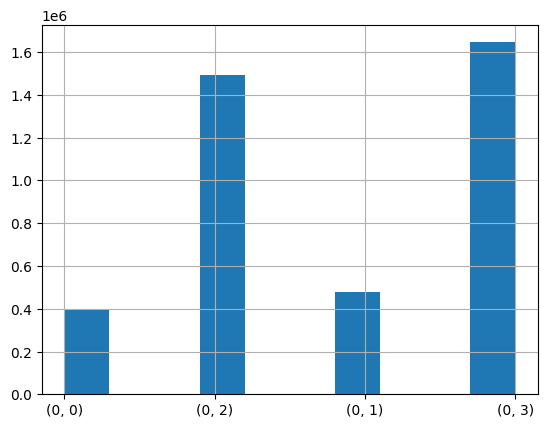

In [7]:
kdigo['subject_aki_range'].hist()

<AxesSubplot:>

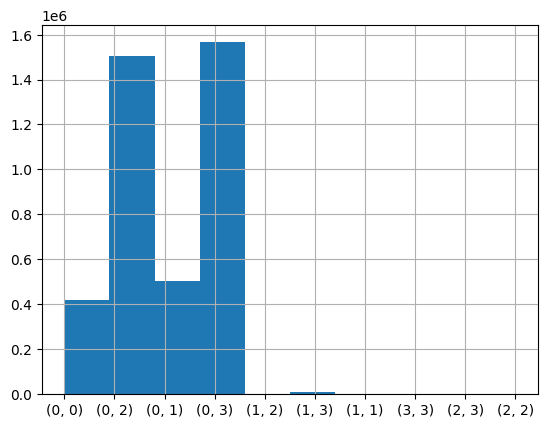

In [8]:
kdigo['icu_aki_range'].hist()

<AxesSubplot:>

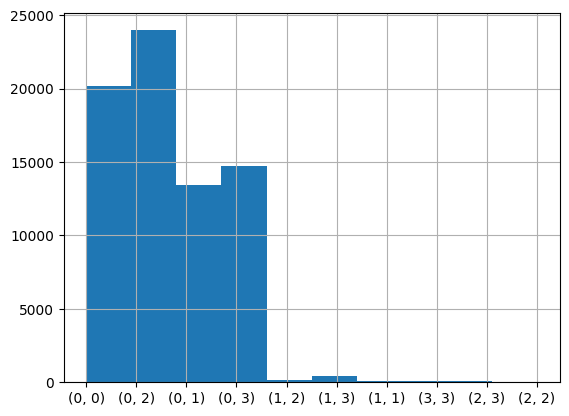

In [23]:
kdigo_by_icu
kdigo_by_icu['aki_range'] = list(map(str, zip(kdigo_by_icu['icu_min_aki'], kdigo_by_icu['icu_max_aki'])))
kdigo_by_icu['icu_count'] = 1

kdigo_by_icu['aki_range'].hist()


In [22]:
kdigo_by_icu

,subject_id,hadm_id,stay_id,intime,hosp_stay_num,icu_stay_num,icu_min_aki,icu_max_aki,pat_count,age,gender,insurance,icu_los,dod,icu_mortality,aki_range
0,10000032,29079034,39553978,2180-07-23 14:00:00,1,1,0,0,1,52.0,F,Medicaid,0.410266,2180-09-09,0,"(0, 0)"
1,10000980,26913865,39765666,2189-06-27 08:42:00,1,1,0,0,1,76.0,F,Medicare,0.497535,2193-08-26,0,"(0, 0)"
2,10001217,24597018,37067082,2157-11-20 19:18:02,1,1,0,0,1,55.0,F,Other,1.118032,None,0,"(0, 0)"
3,10001217,27703517,34592300,2157-12-19 15:42:24,2,1,0,0,0,55.0,F,Other,0.948113,None,0,"(0, 0)"
4,10001725,25563031,31205490,2110-04-11 15:52:22,1,1,0,0,1,46.0,F,Other,1.338588,None,0,"(0, 0)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73176,19999442,26785317,32336619,2148-11-19 14:23:43,1,1,0,0,1,43.0,M,Medicaid,6.950370,None,0,"(0, 0)"
73177,19999625,25304202,31070865,2139-10-10 19:18:00,1,1,0,0,1,82.0,M,Medicare,0.960741,None,0,"(0, 0)"
73178,19999828,25744818,36075953,2149-01-08 18:12:00,1,1,0,0,1,48.0,F,Other,1.790995,None,0,"(0, 0)"
73179,19999840,21033226,38978960,2164-09-12 09:26:28,1,1,0,2,1,58.0,M,Other,5.297766,2164-09-17,1,"(0, 2)"


In [26]:
from tableone import TableOne


In [36]:
[f'({i}, {j})' for i in range(4) for j in range(i, 4)]

['(0, 0)',
 '(0, 1)',
 '(0, 2)',
 '(0, 3)',
 '(1, 1)',
 '(1, 2)',
 '(1, 3)',
 '(2, 2)',
 '(2, 3)',
 '(3, 3)']

In [45]:


columns = [
    "pat_count",
    "icu_count",
    "age", "gender", "insurance",
    'icu_mortality',
    "icu_los",
    "aki_range"
]

categorical = [
    "pat_count",
    "icu_count", 
    "gender", "insurance",
    'icu_mortality',
    "aki_range"
]

order = {
    "pat_count": [1, 0],
#     "icu_count": [1, 0],
    "gender": ["F", "M"],
    "icu_mortality": [1, 0],
    "aki_range": [f'({i}, {j})' for i in range(4) for j in range(i, 4)]
}

limit = {
    "pat_count": 1,
#     "icu_count": 1,
    "gender": 1,
    "icu_mortality": 1,
}

rename = {
    "pat_count": "Distinct patients", 
    "icu_count": "Distinct ICU Admissions",
    "age": "Age", "gender": "Administrative Gender", "insurance": "Insurance",
    "icu_los": "ICU length of stay", 
    "icu_mortality": "In-ICU mortality",
    "aki_range": "ICU AKI Range (min, max)"
}

print('ICU demographics')
icu_table = TableOne(kdigo_by_icu, columns=columns, categorical=categorical, order=order, limit=limit, rename=rename)
display(icu_table)

ICU demographics


Missing        Overall
n                                                         73181
Distinct patients, n (%)        1              0   50920 (69.6)
Distinct ICU Admissions, n (%)  1              0  73181 (100.0)
Age, mean (SD)                                 0    64.7 (16.9)
Administrative Gender, n (%)    F              0   32363 (44.2)
Insurance, n (%)                Medicaid       0     5528 (7.6)
                                Medicare           33091 (45.2)
                                Other              34562 (47.2)
In-ICU mortality, n (%)         1              0     4912 (6.7)
ICU length of stay, mean (SD)                  0      3.5 (4.9)
ICU AKI Range (min, max), n (%) (0, 0)         0   20156 (27.5)
                                (0, 1)             13450 (18.4)
                                (0, 2)             23969 (32.8)
                                (0, 3)             14748 (20.2)
                                (1, 1)                 69 (0.1)
                                (1, 2)                133 (0.2)
                                (1, 3)                452 (0.6)
                                (2, 2)                 11 (0.0)
                                (2, 3)                 84 (0.1)
                                (3, 3)                109 (0.1)